In [2]:
import boto3

region_name = boto3.Session().region_name
region_name

'us-east-2'

In [3]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
role

'arn:aws:iam::410330524497:role/service-role/AmazonSageMaker-ExecutionRole-20220129T122788'

In [4]:
s3_bucket = 'my-cifar100-s3-bucket' 
prefix = 'sagemaker/pytorch-cifar100'

In [5]:
import uuid

checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = f's3://{s3_bucket}/checkpoint-{checkpoint_suffix}'
checkpoint_s3_path

's3://my-cifar100-s3-bucket/checkpoint-ab8fa9e3'

In [6]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
training_input_path = sagemaker_session.upload_data(path='data', bucket=s3_bucket, key_prefix='data/cifar100')
print(f'input spec (in this case, just an S3 path): {training_input_path}')

input spec (in this case, just an S3 path): s3://my-cifar100-s3-bucket/data/cifar100


## Training

In [8]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 1}


estimator = PyTorch(entry_point='cifar100.py',
                    role=role,
                    py_version='py3',
                    framework_version='1.7.1',
                    instance_type='ml.m4.xlarge',
                    instance_count=1,
                    hyperparameters=hyperparameters,
                    base_job_name='cifar100-resnet34',
                    checkpoint_s3_uri = checkpoint_s3_path,
                    debugger_hook_config = False,
                    )

In [9]:
estimator.fit({'training': training_input_path})

2022-01-29 14:07:42 Starting - Starting the training job...
2022-01-29 14:07:44 Starting - Launching requested ML instancesProfilerReport-1643465261: InProgress
...
2022-01-29 14:08:31 Starting - Preparing the instances for training.........
2022-01-29 14:10:12 Downloading - Downloading input data...
2022-01-29 14:10:43 Training - Downloading the training image...
2022-01-29 14:11:11 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-29 14:11:12,680 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-29 14:11:12,682 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-29 14:11:12,695 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-29 14:11:12,704 sagemaker_pytorch_container.training INFO     Invoking user training scrip

In [10]:
model_data = estimator.model_data
model_data

's3://sagemaker-us-east-2-410330524497/cifar100-resnet34-2022-01-29-14-07-41-844/output/model.tar.gz'

## Inference

In [11]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  mountain forest seal mushroom
Predicted:  road forest cattle otter


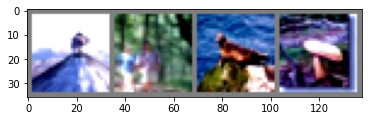

In [12]:
import numpy as np
import torchvision, torch

# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

In [13]:
predictor.delete_endpoint()